In [1]:
from __future__ import print_function, division

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from skimage import io, transform

from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision import transforms, utils

plt.ion()

In [2]:
class FacesFERPlus(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.faces = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.faces.iloc[idx, 1])
        image = io.imread(img_name)
#         image_1 = np.zeros((3, 224, 224), dtype = float)
#         for i in range(48):
#             for j in range(48):
#                 image_1[0][i+88][j+88] = image[i][j]
#                 image_1[1][i+88][j+88] = image[i][j]
#                 image_1[2][i+88][j+88] = image[i][j]
        image_1 = np.zeros((48, 48, 3), dtype = float)
        for i in range(48):
            for j in range(48):
                image_1[i][j][0] = image[i][j]
                image_1[i][j][1] = image[i][j]
                image_1[i][j][2] = image[i][j]
        image_1 = image_1 / 255.0
        image_1 = image_1.astype('float32')
#         image_1 = torch.FloatTensor(image_1.tolist())
        emotions = self.faces.iloc[idx, 2:].as_matrix()
        emotions = emotions.astype(np.long)
        emotions_1 = np.argmax(emotions)
        emotions = np.asarray([emotions_1]).astype(np.long)
#         emotions = torch.LongTensor(emotions.tolist())
        
        sample = {'image': image_1, 'emotions': emotions}


        if self.transform:
            sample = self.transform(sample)


        return sample

In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, emotions = sample['image'], sample['emotions']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        sample = {'image': img, 'emotions': emotions}
        
        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, emotions = sample['image'], sample['emotions']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.FloatTensor(image.tolist()),
                'emotions': torch.LongTensor(emotions.tolist())}

In [4]:
data_transforms = transforms.Compose([
        Rescale(224),
        ToTensor()
    ])

face_dataset_tr = FacesFERPlus(csv_file='Dataset/FERPlus/Training.csv',
                            root_dir='Dataset/FERPlus/FER2013Train')

face_dataset_va = FacesFERPlus(csv_file='Dataset/FERPlus/Validation.csv',
                            root_dir='Dataset/FERPlus/FER2013Valid')

face_dataset_train = FacesFERPlus(csv_file='Dataset/FERPlus/Training.csv',
                            root_dir='Dataset/FERPlus/FER2013Train', transform = data_transforms)

face_dataset_valid = FacesFERPlus(csv_file='Dataset/FERPlus/Validation.csv',
                            root_dir='Dataset/FERPlus/FER2013Valid', transform = data_transforms)


dataloaders_train = torch.utils.data.DataLoader(face_dataset_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=0)

dataloaders_valid = torch.utils.data.DataLoader(face_dataset_valid,
                                             batch_size=32, shuffle=True,
                                             num_workers=0)

dataset_sizes = [len(face_dataset_train), len(face_dataset_valid)]
print(dataset_sizes)

[28561, 3579]


In [5]:
for i in range(len(face_dataset_train)):
    sample = face_dataset_train[i]

    print(i, sample['image'].size(), sample['emotions'].size())
    print(type(sample['image']))

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([1])
<class 'torch.Tensor'>
1 torch.Size([3, 224, 224]) torch.Size([1])
<class 'torch.Tensor'>
2 torch.Size([3, 224, 224]) torch.Size([1])
<class 'torch.Tensor'>
3 torch.Size([3, 224, 224]) torch.Size([1])
<class 'torch.Tensor'>


C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (48, 48, 3) (1,)
1 (48, 48, 3) (1,)
2 (48, 48, 3) (1,)
3 (48, 48, 3) (1,)
4 (48, 48, 3) (1,)


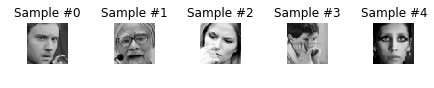

In [6]:
fig = plt.figure()

for i in range(len(face_dataset_tr)):
    sample = face_dataset_tr[i]

    print(i, sample['image'].shape, sample['emotions'].shape)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    image = sample['image']
    plt.imshow(image)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (48, 48, 3) (1,)
1 (48, 48, 3) (1,)
2 (48, 48, 3) (1,)
3 (48, 48, 3) (1,)
4 (48, 48, 3) (1,)


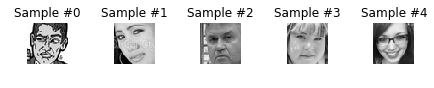

In [7]:
fig = plt.figure()

for i in range(len(face_dataset_va)):
    sample = face_dataset_va[i]
    print(i, sample['image'].shape, sample['emotions'].shape)

    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(sample['image'])
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


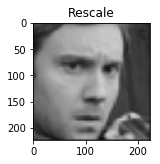

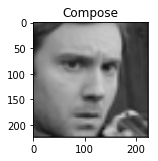

In [8]:
scale = Rescale(224)
composed = transforms.Compose([Rescale(224)])

def show_landmarks(image, emotions):
    """Show image with landmarks"""
    plt.imshow(image)
#     plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset_tr[0]
for i, tsfrm in enumerate([scale, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 1])


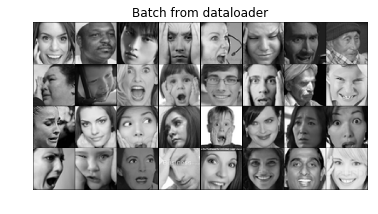

In [9]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['emotions']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
#         plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
#                     landmarks_batch[i, :, 1].numpy(),
#                     s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloaders_train):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['emotions'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in range(2):            
            if phase == 0:
                dataloaders = dataloaders_train
                scheduler.step()
                model.train()
            else:
                dataloaders = dataloaders_valid
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i_batch, sample_batched in enumerate(dataloaders):
                inputs = sample_batched['image']
                labels = sample_batched['emotions']
                labels = labels.squeeze(1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 0):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 0:
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    time_elapsed = time.time() - since
    print('Training complete in {: .0f}m {:0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("Predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

In [16]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, 
                      exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\biplab\AppData\Local\conda\conda\envs\pytorchgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
torch.save(model_ft.state_dict(), "non_aligned_pretrain_scale.pt")

In [ ]:
visualize_model(model_ft)